In [18]:
# Disable jedi autocompleter
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import glob
import seaborn as sns

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
all_da_cube_csvs = glob.glob('./**/**/**/*.csv')
all_da_cube_csvs

['./icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo/results/results.csv',
 './icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo_idx_16/results/results.csv',
 './icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo_idx_8/results/results.csv',
 './icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_constant_steph_pt2_redo_idx_1/results/results.csv',
 './icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_constant_steph_pt2_redo_idx_23/results/results.csv',
 './icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_constant_steph_pt2_redo_idx_19/results/results.csv',
 './icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_constant_steph_pt2_redo/results/results.csv',
 './icra_real_cube_constant_steph_pt1_ALL_Trials/icra_real_cube_constant_steph_pt1_redo/results/results.csv',
 './icra_real_cube_constant_steph_pt1_ALL_Trials/icra_real_cube_constant_steph_pt1_redo

In [3]:
counter = 0

In [20]:
df_arr = [pd.read_csv(csv_name) for csv_name in all_da_cube_csvs]
len(df_arr)

11

In [15]:
counter += 1
counter

12

In [21]:
sample_multiple_df = pd.DataFrame().append(df_arr)
sample_multiple_df

,Unnamed: 0,x_noise,y_noise,z_noise,Success,trans_err,quat_dist
0,0,0.000,0.0000,0.0,True,0.000000,0.0
1,1,-0.010,0.0100,0.0,True,-0.014142,0.0
2,2,0.010,0.0100,0.0,True,0.014142,0.0
3,3,0.020,0.0200,0.0,True,0.028284,0.0
4,4,-0.020,0.0200,0.0,False,-0.028284,0.0
...,...,...,...,...,...,...,...
1,1,-0.010,0.0275,0.0,True,-0.029262,0.0
2,2,0.000,0.0275,0.0,False,0.000000,0.0
3,3,0.010,0.0225,0.0,False,0.024622,0.0
4,4,0.005,0.0250,0.0,False,0.025495,0.0


In [22]:
# group by x and y noise, and the success value is attributed to the max value
average_success_per_point = sample_multiple_df.groupby(['x_noise', 'y_noise']).agg('count')
average_success_per_point

Unnamed: 0  z_noise  Success  trans_err  quat_dist
x_noise y_noise                                                    
-0.025  0.0250            3        3        3          3          3
-0.020  0.0150            3        3        3          3          3
        0.0175            4        4        4          4          4
        0.0200            3        3        3          3          3
        0.0250            3        3        3          3          3
        0.0275            3        3        3          3          3
-0.010  0.0100            4        4        4          4          4
        0.0200            3        3        3          3          3
        0.0250            3        3        3          3          3
        0.0275            3        3        3          3          3
 0.000  0.0000            3        3        3          3          3
        0.0200            3        3        3          3          3
        0.0250            4        4        4          4          4
        0.0275            3        3        3          3          3
 0.005  0.0250            3        3        3          3          3
 0.010  0.0100            3        3        3          3          3
        0.0200            3        3        3          3          3
        0.0225            3        3        3          3          3
        0.0250            3        3        3          3          3
 0.015  0.0200            3        3        3          3          3
 0.020  0.0150            3        3        3          3          3
        0.0175            4        4        4          4          4
        0.0200            3        3        3          3          3
        0.0250            3        3        3          3          3

### i grabbed the csv and im analyzing on my computer bye bye

In [23]:
sample_multiple_df.to_csv('icra_real_cube_constant.csv')

### jk i have to clean some more timeseries data fml

end goal: timeseries-based csv that i can visualize on my own computer


In [24]:
# im too lazy to go through import hell so let's just do this...

from pathlib import Path


class ExperimentAnalysis:
    """
    TODO: eventually replace visualize_irl.py with this object!
    """

    def __init__(self, log_dir, base_location=np.array([0, 0, 0]),
                 ideal_grasp_quat=np.array([np.pi / 2, 0, 0, np.pi / 2])):
        # make results directory first...
        assert Path(log_dir).exists(), 'Check that the log directory ' + log_dir + ' exists.'

        episode_dir = os.path.join(log_dir, 'episodes/')

        # get filepaths from episodes directory.
        reward_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'reward*.npy')))
        obs_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'obs*.npy')))
        next_obs_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'next_obs*.npy')))
        action_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'action*.npy')))

        # trans_err_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'translation_err*.npy')))
        # quat_dist_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'quat_dist*.npy')))

        start_pose_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'start_pose*.npy')))
        noise_arr_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'noise_arr*.npy')))

        success_arr = np.array([np.load(filepath)[-1] for filepath in reward_filepaths])
        noise_arr = np.array([np.load(filepath) for filepath in noise_arr_filepaths])

        x_noise_arr = noise_arr[:, 0]
        y_noise_arr = noise_arr[:, 1]
        z_noise_arr = noise_arr[:, 2]
        roll_noise_arr = noise_arr[:, 3]
        pitch_noise_arr = noise_arr[:, 4]
        yaw_noise_arr = noise_arr[:, 5]

        start_pose_arr = np.array([np.load(filepath) for filepath in start_pose_filepaths])
        hand_orientation_quat_arr = start_pose_arr[:, -4:]  # last 4 elems are x,y,z,w quaternion...

        # the dataframe
        self.df = pd.DataFrame(
            {'x_noise': x_noise_arr, 'y_noise': y_noise_arr, 'z_noise': z_noise_arr, 'roll_noise': roll_noise_arr,
             'pitch_noise': pitch_noise_arr, 'yaw_noise': yaw_noise_arr, 'Success': success_arr == True})

        # calculation stuff: do this after defining dataframe

        # step 1: get translation_err. flips to neg value if x is negative
        self.df['trans_err'] = self.df[['x_noise', 'y_noise', 'z_noise']].apply(
            lambda x: np.sign(x[0] + 0.00001) * np.sqrt(np.sum((x.to_numpy() - base_location) ** 2)), axis=1)

        # step 2: get quat distance
        quaternion_dot_prod = np.dot(hand_orientation_quat_arr, ideal_grasp_quat)
        angle_difference = np.arccos(quaternion_dot_prod)  # in degrees
        quat_distance = np.rad2deg(angle_difference)  # in radians
        quat_distance = np.nan_to_num(quat_distance, nan=0, posinf=0,
                                      neginf=0)  # for now just set values of positive infinity and negative infinity to also round to 0
        self.df['quat_dist'] = quat_distance

        """
        replay buffer stuff
        """
        self.reward_buffer = np.array([np.load(filepath) for filepath in reward_filepaths])
        self.obs_buffer = np.array([np.load(filepath) for filepath in obs_filepaths])
        self.action_buffer = np.array([np.load(filepath, allow_pickle=True) for filepath in action_filepaths])
        self.next_obs_buffer = np.array([np.load(filepath) for filepath in next_obs_filepaths])

    def __len__(self):
        """
        Returns
        -------
        size of the episode memory

        """
        return len(self.df)

    def get_episode_data(self, episode_idx):
        """
        get the episode data

        Parameters
        ----------
        episode_idx

        Returns
        -------

        """
        assert 0 <= episode_idx < len(self.df), "Requested an episode index that doesn't exist: " + episode_idx

        buffer_res = {
            'reward': self.reward_buffer[episode_idx],
            'obs': self.obs_buffer[episode_idx],
            'action': self.action_buffer[episode_idx],
            'next_obs': self.next_obs_buffer[episode_idx]
        }

        res = {
            'df': self.df.iloc[episode_idx],
            'buffer': buffer_res
        }

        return res


### what should the structure of the "timeseries esque" thing be like?

per timeslice:

#### general info

1. noises (x, y, z, roll, pitch, yaw)
2. success
3. translation err


#### in each timesllice:

1. sarsa tuple

#### generated

1. is done (juust if all action is 0)


### HOW TO MAKE THIS CODE WORK!

YOU SHOULD FEED IN A LIST OF ANY TOP LEVEL FOLDERS YOU WANT TO WORK to `episode_folders`. Then you can run the rest

In [25]:
# step 1: get all the top level experiment folders
episode_folders = [os.path.abspath(os.path.join(csv_filepath, '../..')) for csv_filepath in all_da_cube_csvs]
episode_folders[0]  # example folder

'/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo'

In [26]:
episode_folders

['/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo',
 '/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo_idx_16',
 '/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt3_ALL_Trials/icra_real_cube_constant_steph_pt3_redo_idx_8',
 '/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_constant_steph_pt2_redo_idx_1',
 '/home/mechagodzilla/sim-to-real-kinova/src/sim-to-real-kinova-master/openai_gym_kinova/src/experiment_pain/aaaaa/icra_real_cube_constant_steph_pt2_ALL_Trials/icra_real_cube_co

In [27]:
global_experiment_id_arr = []
global_timestep_arr = []
global_success_arr = []
global_noise_arr = []
global_trans_err_arr = []
global_quat_dist_arr = []
global_action_arr = []
global_obs_arr = []


In [28]:
num_timesteps = 45
unique_experiment_id_counter = 0

for trial_idx in range(len(episode_folders)):
    trial_analysis = ExperimentAnalysis(episode_folders[trial_idx])
    
    for experiment_idx in range(len(trial_analysis)):
        real_anal_data = trial_analysis.get_episode_data(experiment_idx)

        # get actions
        real_action = real_anal_data['buffer']['action']

        # get observations
        real_obs = real_anal_data['buffer']['obs']

        # get rewards
        real_success = real_anal_data['df']['Success']

        # for sanity check
        # TODO: include roll pitch yaw
        real_noise = real_anal_data['df'][['x_noise', 'y_noise', 'z_noise', 'roll_noise', 'pitch_noise', 'yaw_noise']].to_numpy()

        real_trans_err = real_anal_data['df']['trans_err']
        real_quat_dist = real_anal_data['df']['quat_dist']

        # make an example df of a single trial

        # experiment id
        local_experiment_id_arr = [unique_experiment_id_counter] * num_timesteps

        # timesteps
        local_timestep_arr = list(range(num_timesteps))

        # success
        local_success_arr = [real_success] * num_timesteps

        # noise arr (will stack noises here)
        local_noise_arr = [real_noise] * num_timesteps

        # intermediate features
        local_trans_err_arr = [real_trans_err] * num_timesteps
        local_quat_dist_arr = [real_quat_dist] * num_timesteps

        # conversion to lists. we don't want to numpy append our stuff bc that makes copies each time (np arrays are immutable)
        local_action_arr = list(real_action)
        local_obs_arr = list(real_obs)

        # GOD
        global_experiment_id_arr += local_experiment_id_arr
        global_timestep_arr += local_timestep_arr
        global_success_arr += local_success_arr
        global_noise_arr += local_noise_arr
        global_trans_err_arr += local_trans_err_arr
        global_quat_dist_arr += local_quat_dist_arr
        global_action_arr += local_action_arr
        global_obs_arr += local_obs_arr
        
        # increment experiment counter
        unique_experiment_id_counter += 1

/home/mechagodzilla/kinova_venv/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in arccos


In [29]:
# I smush all the data into one large matrix containing all the info.
big_messy_data_arr = np.concatenate((np.expand_dims(global_experiment_id_arr, 1), np.expand_dims(global_timestep_arr, 1), np.expand_dims(global_success_arr, 1), np.array(global_noise_arr), np.expand_dims(global_trans_err_arr, 1), np.expand_dims(global_quat_dist_arr, 1), np.array(global_action_arr), np.array(global_obs_arr)), axis=1)
# big_messy_data_arr.shape


# making the column names

# not pictured: 'experiment_id', 
generic_column_names = ['experiment_id', 'timestep', 'success', 'x_noise', 'y_noise', 'z_noise', 'roll_noise', 'pitch_noise', 'yaw_noise', 'trans_err', 'quat_dist']

# make finger actions 0-3
action_names = ['act_finger_'+str(fing_num) for fing_num in range(3)]

# make columns 0-25
obs_names = ['obs_'+str(obs_num) for obs_num in range(26)]

# all the column names
full_df_cols = generic_column_names + action_names + obs_names
full_df_cols

['experiment_id',
 'timestep',
 'success',
 'x_noise',
 'y_noise',
 'z_noise',
 'roll_noise',
 'pitch_noise',
 'yaw_noise',
 'trans_err',
 'quat_dist',
 'act_finger_0',
 'act_finger_1',
 'act_finger_2',
 'obs_0',
 'obs_1',
 'obs_2',
 'obs_3',
 'obs_4',
 'obs_5',
 'obs_6',
 'obs_7',
 'obs_8',
 'obs_9',
 'obs_10',
 'obs_11',
 'obs_12',
 'obs_13',
 'obs_14',
 'obs_15',
 'obs_16',
 'obs_17',
 'obs_18',
 'obs_19',
 'obs_20',
 'obs_21',
 'obs_22',
 'obs_23',
 'obs_24',
 'obs_25']

In [30]:
timestepped_data = pd.DataFrame(data=big_messy_data_arr, columns=full_df_cols)
timestepped_data

,experiment_id,timestep,success,x_noise,y_noise,z_noise,roll_noise,pitch_noise,yaw_noise,trans_err,...,obs_16,obs_17,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,obs_24,obs_25
0,0,0,True,0,0,0,0,0,0,0,...,3.30425,1.96863,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939
1,0,1,True,0,0,0,0,0,0,0,...,3.30425,1.96863,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939
2,0,2,True,0,0,0,0,0,0,0,...,3.30425,1.96863,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939
3,0,3,True,0,0,0,0,0,0,0,...,3.30425,1.96863,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939
4,0,4,True,0,0,0,0,0,0,0,...,3.29523,1.96183,3.2922,0.02,0.02,0.105,0.0861697,0.0850746,0.104147,0.111563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,75,40,False,0.015,0.02,0,0,0,0,0.025,...,3.35274,1.06765,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774
3416,75,41,False,0.015,0.02,0,0,0,0,0.025,...,3.35274,1.06765,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774
3417,75,42,False,0.015,0.02,0,0,0,0,0.025,...,3.35274,1.06765,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774
3418,75,43,False,0.015,0.02,0,0,0,0,0.025,...,3.35274,1.06765,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774


### LOOK BELOW! MAKE SURE THE SHAPE AND POLICY IS CORRECT!!

In [34]:
# optional: add shape and policy type data too

# assumbe only cubes
shape_arr = ['CubeM'] * big_messy_data_arr.shape[0]
policy_arr = ['constant'] * big_messy_data_arr.shape[0]
additional_cols = ['shape', 'policy']

bigger_messy_data_arr = np.concatenate((big_messy_data_arr, np.expand_dims(shape_arr, 1), np.expand_dims(policy_arr, 1)), axis=1)
timestepped_data_with_shape_policy = pd.DataFrame(data=bigger_messy_data_arr, columns=full_df_cols + additional_cols)
timestepped_data_with_shape_policy

,experiment_id,timestep,success,x_noise,y_noise,z_noise,roll_noise,pitch_noise,yaw_noise,trans_err,...,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,obs_24,obs_25,shape,policy
0,0,0,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
1,0,1,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
2,0,2,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
3,0,3,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
4,0,4,True,0,0,0,0,0,0,0,...,3.2922,0.02,0.02,0.105,0.0861697,0.0850746,0.104147,0.111563,CubeM,constant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,75,40,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3416,75,41,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3417,75,42,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3418,75,43,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant


In [35]:
timestepped_data_with_shape_policy.to_csv('icra_real_cube_constant_timesteps.csv')  # save

### note to nigel: when you collect data, please use the same yaml, and just modify the "start_index" attribute. the data processing methods used (especially the comparison functions) do NOT mesh well with different orderings of data, and make very strong assumptions about meshing of data

In [36]:
bruh_df = timestepped_data_with_shape_policy
bruh_df

,experiment_id,timestep,success,x_noise,y_noise,z_noise,roll_noise,pitch_noise,yaw_noise,trans_err,...,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,obs_24,obs_25,shape,policy
0,0,0,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
1,0,1,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
2,0,2,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
3,0,3,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
4,0,4,True,0,0,0,0,0,0,0,...,3.2922,0.02,0.02,0.105,0.0861697,0.0850746,0.104147,0.111563,CubeM,constant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,75,40,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3416,75,41,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3417,75,42,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant
3418,75,43,False,0.015,0.02,0,0,0,0,0.025,...,3.31267,0.02,0.02,0.105,0.0923488,0.0699597,0.077872,0.056774,CubeM,constant


<AxesSubplot:xlabel='timestep', ylabel='obs_12'>

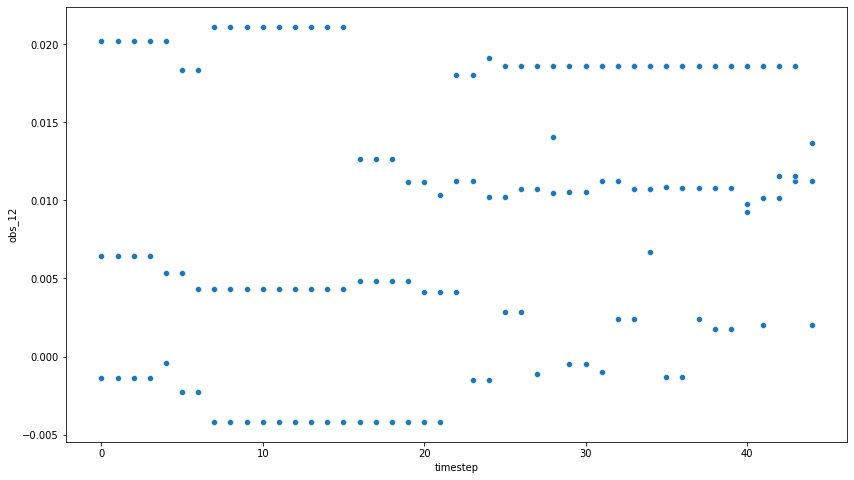

In [41]:
plt.figure(figsize=(14, 8))

sns.scatterplot(data=bruh_df[(bruh_df['x_noise']==0.0) & (bruh_df['y_noise']==0.0)], x='timestep', y='obs_12')

,experiment_id,timestep,success,x_noise,y_noise,z_noise,roll_noise,pitch_noise,yaw_noise,trans_err,...,obs_18,obs_19,obs_20,obs_21,obs_22,obs_23,obs_24,obs_25,shape,policy
0,0,0,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
1,0,1,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
2,0,2,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
3,0,3,True,0,0,0,0,0,0,0,...,3.30026,0.02,0.02,0.105,0.08541,0.0843471,0.103099,0.110939,CubeM,constant
4,0,4,True,0,0,0,0,0,0,0,...,3.2922,0.02,0.02,0.105,0.0861697,0.0850746,0.104147,0.111563,CubeM,constant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,52,40,True,0,0,0,0,0,0,0,...,3.21832,0.02,0.02,0.105,0.0791702,0.0629001,0.0707059,0.0551834,CubeM,constant
2381,52,41,True,0,0,0,0,0,0,0,...,3.20736,0.02,0.02,0.105,0.0762764,0.0592589,0.0674666,0.0505479,CubeM,constant
2382,52,42,True,0,0,0,0,0,0,0,...,3.21832,0.02,0.02,0.105,0.0836998,0.0683179,0.076222,0.0619385,CubeM,constant
2383,52,43,True,0,0,0,0,0,0,0,...,3.21832,0.02,0.02,0.105,0.0836998,0.0683179,0.076222,0.0619385,CubeM,constant
